**DETECTION OF FRAUD TRANSACTION USING CLASSIFICATION**

**Introduction**:

- The number of online transactions and the frequency of fraud increase in tandem with the growth of the digital landscape. For financial institutions, e-commerce platforms, and consumers who have to cope with the fallout from fraudulent transactions, this surge presents serious issues. Conventional fraud detection systems, which are frequently based on rule-based algorithms, are only marginally effective and find it difficult to stay up to date with the ever-evolving techniques employed by scammers.

- To address these issues, this project is useful in creating an advanced machine learning model that enhances the detection of fraudulent transactions by combining traditional and novel data features. The objective of this sophisticated model is to integrate multiple dimensions of transaction data, including economic indicators, geographic analysis, and behavioral tendencies. The main goal is to improve the accuracy and efficiency of fraud detection by dynamically evaluating and classifying each transaction risk level.


**STEP - 1: Creating Normalized Database**

In [1]:
import sqlite3
from sqlite3 import Error

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

In [3]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [4]:
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

**Creating the Transaction, Users and UserAddresses tables**

In [5]:
conn_norm = create_connection("normalized.db", delete_db = True)

create_transaction_table_sql = """CREATE TABLE IF NOT EXISTS Transactions (
    transaction_id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    hour_of_day INTEGER,
    sending_address TEXT,
    receiving_address TEXT,
    amount REAL,
    transaction_type TEXT,
    location_region TEXT,
    ip_prefix TEXT,
    purchase_pattern TEXT,
    risk_score REAL,
    anomaly TEXT
);"""

create_table(conn_norm, create_transaction_table_sql)

create_users_table_sql = """CREATE TABLE Users (
    user_id INTEGER PRIMARY KEY AUTOINCREMENT,
    login_frequency INTEGER,
    session_duration INTEGER,
    age_group TEXT
);"""
create_table(conn_norm, create_users_table_sql)

create_UserAddresses_table_sql = """CREATE TABLE UserAddresses (
    user_address_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id INTEGER,
    address TEXT,
    FOREIGN KEY (user_id) REFERENCES Users(user_id)
);"""
create_table(conn_norm, create_UserAddresses_table_sql)

conn_norm.commit()
conn_norm.close()

In [6]:
def insert_transaction(conn, values):
    sql = ''' INSERT INTO Transactions (
              timestamp, hour_of_day, sending_address, receiving_address, amount,
              transaction_type, location_region, ip_prefix, purchase_pattern, risk_score, anomaly)
              VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

In [7]:
def insert_users(conn, values):
    sql = '''INSERT INTO Users (login_frequency, session_duration, age_group)
          VALUES (?, ?, ?)'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

In [8]:
def insert_user_address(conn, values):
    sql = '''INSERT INTO UserAddresses(user_id, address)
          VALUES ((SELECT MAX(user_id) FROM Users), ?)'''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

**Inserting the values into tables from the data set which in csv format**

In [9]:
import csv

conn_norm2= sqlite3.connect('normalized.db')
csv_file=open('metaverse_transactions_dataset.csv')
csv_reader = csv.DictReader(csv_file)
for row in csv_reader:
    transaction_table_values = (row['timestamp'], row['hour_of_day'], row['sending_address'], row['receiving_address'],
                       row['amount'], row['transaction_type'], row['location_region'], row['ip_prefix'],
                       row['purchase_pattern'], row['risk_score'], row['anomaly'])
    insert_transaction(conn_norm2, transaction_table_values)
    user_table_values = (row['login_frequency'], row['session_duration'], row['age_group'])
    insert_users(conn_norm2, user_table_values)
    userAddress_table_values = (row['sending_address'],)
    insert_user_address(conn_norm2, userAddress_table_values)

conn_norm2.commit()
conn_norm2.close()

**STEP 2: Data Preprocessing**

**Fetching data from the database into a Pandas DataFrame**

In [10]:
import pandas as pd
conn3 = sqlite3.connect('normalized.db')

sql_query = ''' SELECT T.*, U.login_frequency, U.session_duration, U.age_group
FROM Transactions T
JOIN UserAddresses UA ON T.sending_address = UA.address
JOIN Users U ON UA.user_id = U.user_id
'''

df = pd.read_sql_query(sql_query, conn3)
conn3.close()
print(df.head())

   transaction_id            timestamp  hour_of_day  \
0           65041  2022-01-17 17:06:27           17   
1           51491  2022-01-18 10:49:32           10   
2           27101  2022-01-29 18:28:19           18   
3           32521  2022-02-09 02:56:02            2   
4           35231  2022-02-09 14:22:46           14   

                              sending_address  \
0  0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   
1  0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   
2  0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   
3  0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   
4  0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da   

                            receiving_address      amount transaction_type  \
0  0x39f82e1c09bc6d7baccc1e79e5621ff812f50572  456.127541             sale   
1  0x39f82e1c09bc6d7baccc1e79e5621ff812f50572  597.757157         transfer   
2  0x39f82e1c09bc6d7baccc1e79e5621ff812f50572  741.489137             sale   
3  0x39f82e1c09bc6d7baccc1e79e5621ff812f50572  336.659612     


**Splitting the data into train data and test data**


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['anomaly'])
y = df['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Categorize data into categorical and numerical value**

In [12]:
# Categorize data into categorical and numerical values
categorical_cols = ['transaction_type', 'location_region', 'ip_prefix', 'purchase_pattern', 'age_group']
numerical_cols = ['hour_of_day', 'amount', 'risk_score', 'login_frequency', 'session_duration']

# Check for null and missing values
print("Null/Missing Values:")
print(X_train.isnull().sum())

# Data types correction
X_train['timestamp'] = pd.to_datetime(X_train['timestamp'])

Null/Missing Values:
transaction_id       0
timestamp            0
hour_of_day          0
sending_address      0
receiving_address    0
amount               0
transaction_type     0
location_region      0
ip_prefix            0
purchase_pattern     0
risk_score           0
login_frequency      0
session_duration     0
age_group            0
dtype: int64


**PLOTS**

**Feature correlation heatmap**

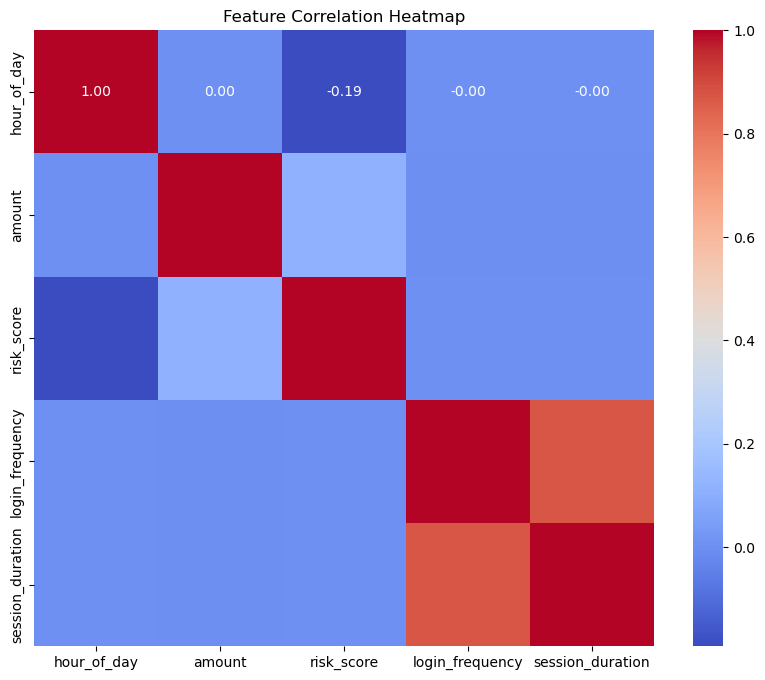

In [13]:
# Plots
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
sns.heatmap(X_train[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


**Create the violin plots**

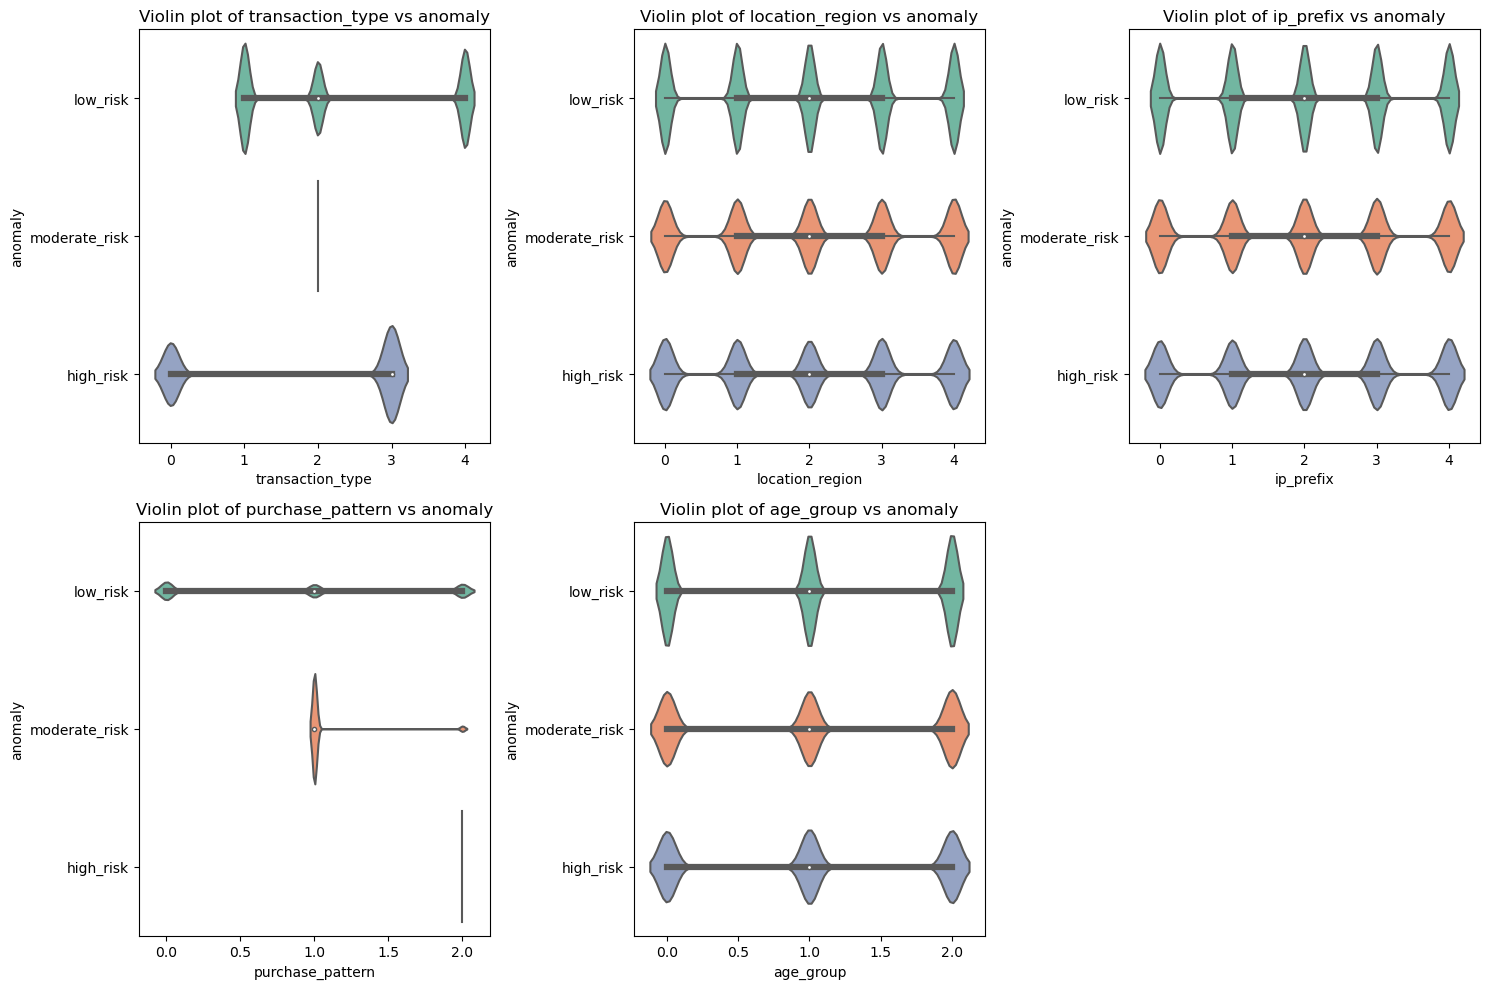

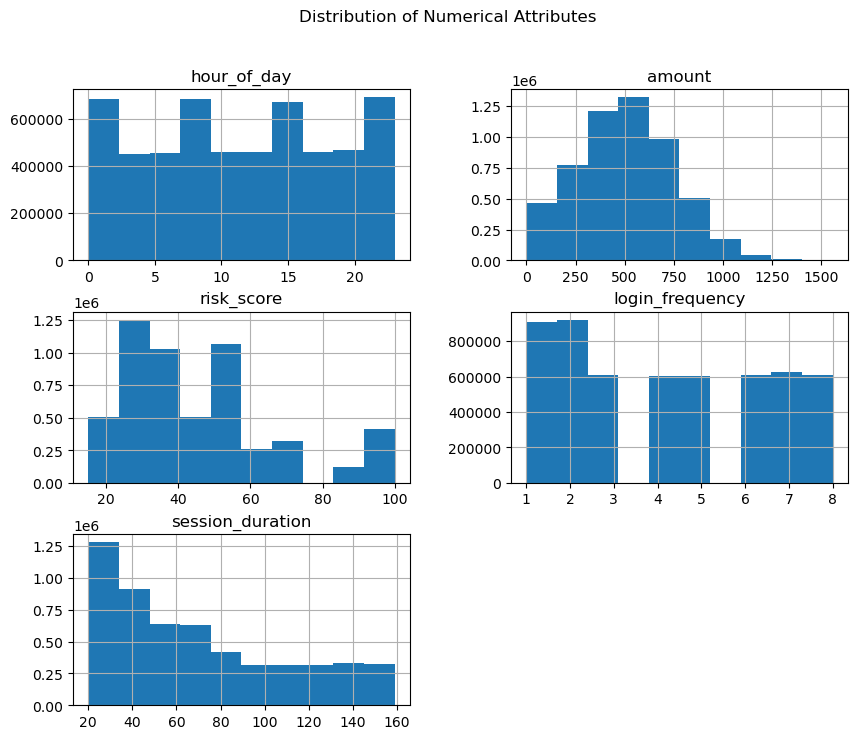

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x=X_train[col], y=y_train, palette='Set2', split=True)
    plt.title(f'Violin plot of {col} vs anomaly')
plt.tight_layout()
plt.show()

X_train[numerical_cols].hist(figsize=(10, 8))
plt.suptitle('Distribution of Numerical Attributes')
plt.show()

**Develop a class-based preprocessor:**

- **Address null and missing values**.
 
- **Manage non-normal distributions**.

- **Implement one-hot encoding for categorical values**.

- **Scale the data**.


In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with median
    ('scaler', StandardScaler())  # Standardize the features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing values with most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_processed = preprocessor.fit_transform(X_train)

X_test_processed = preprocessor.transform(X_test)


**STEP - 3: Model Training and Optimization**

**Register all experiments and models in MLFlow on Dagshub.**

In [18]:
import mlflow
import dagshub
dagshub.init(repo_owner='sneha.pydipati', repo_name='my-first-repo', mlflow=True)

Initialized MLflow to track repo "sneha.pydipati/my-first-repo"

Repository sneha.pydipati/my-first-repo initialized!

**Set mlflow to a right URI**

In [19]:
mlflow.set_tracking_uri('https://dagshub.com/sneha.pydipati/EAS_503.mlflow')

**Train and Make Predictions using Gaussian Naive Bayes classifier**

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import mlflow

# Train Gaussian Naive Bayes classifier
model = GaussianNB()
model.fit(X_train_processed, y_train)

# Make predictions on test data
y_pred = model.predict(X_test_processed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')  
conf_matrix = confusion_matrix(y_test, y_pred)

mlflow.set_experiment("Gaussian NaiveBayes")

# Register metrics in MLFlow
with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

In [21]:
print("accuracy: ",accuracy)
print("balanced_accuracy: ",balanced_accuracy)
print("f1_score: ",f1)
print("precision: ",precision)
print("recall: ",recall)
print("conf_matrix: "+"\n",conf_matrix)

accuracy:  0.7904139493956458
balanced_accuracy:  0.9135436945217964
f1_score:  0.7872104470847203
precision:  0.7809528602813726
recall:  0.9135436945217964
conf_matrix: 
 [[113192      0      0]
 [     0 820243 287249]
 [     0      0 149870]]


In [22]:
from sklearn.metrics import classification_report

results = classification_report(y_test, y_pred)
print(results)

               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00    113192
     low_risk       1.00      0.74      0.85   1107492
moderate_risk       0.34      1.00      0.51    149870

     accuracy                           0.79   1370554
    macro avg       0.78      0.91      0.79   1370554
 weighted avg       0.93      0.79      0.83   1370554



**Train and Make Predictions using Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()
model2.fit(X_train_processed, y_train)

# Make predictions on test data
y_pred2 = model2.predict(X_test_processed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred2)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2, average='macro')
precision = precision_score(y_test, y_pred2, average='macro')
recall = recall_score(y_test, y_pred2, average='macro')  
conf_matrix = confusion_matrix(y_test, y_pred2)

mlflow.set_experiment("MLflow LogisticRegression")
# Register metrics in MLFlow
with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

C:\Users\sneha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
print("accuracy: ",accuracy)
print("balanced_accuracy: ",balanced_accuracy)
print("f1_score: ",f1)
print("precision: ",precision)
print("recall: ",recall)
print("conf_matrix: "+"\n",conf_matrix)

accuracy:  1.0
balanced_accuracy:  1.0
f1_score:  1.0
precision:  1.0
recall:  1.0
conf_matrix: 
 [[ 113192       0       0]
 [      0 1107492       0]
 [      0       0  149870]]


In [25]:
from sklearn.metrics import classification_report

results = classification_report(y_test, y_pred)
print(results)

               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00    113192
     low_risk       1.00      0.74      0.85   1107492
moderate_risk       0.34      1.00      0.51    149870

     accuracy                           0.79   1370554
    macro avg       0.78      0.91      0.79   1370554
 weighted avg       0.93      0.79      0.83   1370554



**Train and Make Predictions using Random Forest Classifier**

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest classifier
model3 = RandomForestClassifier()
model3.fit(X_train_processed, y_train)

# Make predictions on test data
y_pred3 = model3.predict(X_test_processed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred3)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred3)
f1 = f1_score(y_test, y_pred3, average='macro')
precision = precision_score(y_test, y_pred3, average='macro')
recall = recall_score(y_test, y_pred3, average='macro')  
conf_matrix = confusion_matrix(y_test, y_pred3)

mlflow.set_experiment("MLflow RandomForest")
# Register metrics in MLFlow
with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_artifact("mlruns/artifacts")
    mlflow.log_artifacts("RF_Output")

In [40]:
from mlflow.models import infer_signature
signature = infer_signature(X_test_processed, y_pred)
mlflow.sklearn.log_model(
        sk_model=model3,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="random-forest-model",
    )

C:\Users\sneha\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'random-forest-model'.
2024/05/16 17:10:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-model, version 1
Created version '1' of model 'random-forest-model'.


In [27]:
print("accuracy: ",accuracy)
print("balanced_accuracy: ",balanced_accuracy)
print("f1_score: ",f1)
print("precision: ",precision)
print("recall: ",recall)
print("conf_matrix: "+"\n",conf_matrix)

accuracy:  1.0
balanced_accuracy:  1.0
f1_score:  1.0
precision:  1.0
recall:  1.0
conf_matrix: 
 [[ 113192       0       0]
 [      0 1107492       0]
 [      0       0  149870]]


In [28]:
from sklearn.metrics import classification_report

results = classification_report(y_test, y_pred)
print(results)

               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00    113192
     low_risk       1.00      0.74      0.85   1107492
moderate_risk       0.34      1.00      0.51    149870

     accuracy                           0.79   1370554
    macro avg       0.78      0.91      0.79   1370554
 weighted avg       0.93      0.79      0.83   1370554



**Perform hyperparameter tuning and record scores in MLFlow**

- To perform hyperparameter tuning on the models we can utilize techniques like grid search to find the optimal hyperparameters.

- We define the models (Logistic Regression, Random Forest, and Gradient Boosting) along with the hyperparameters to tune.
- 
We perform grid search cross-validation to find the best hyperparameters for each model.
- 
We train each model with the best hyperparameters on the training data and evaluate its performance on the test data
- .
We register the evaluation metrics, best hyperparameters, and the model name in MLFlow for each model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

models = {
    #"Logistic Regression": (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 4, 5]})
}

for name, (classification_model, param_grid) in models.items():
    # Perform grid search cross-validation
    grid_search = GridSearchCV(estimator=classification_model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_processed, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test_processed)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    mlflow.set_experiment(f"hyperParameter Tuning for {classification_model}")
    # Register metrics in MLFlow
    with mlflow.start_run():
        mlflow.log_param("model", name)
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)

**Consider feature selection (dropping features) and feature engineering (creating features)**

- Train models to get feature importances

- Experiment with reduced feature set

**Generate New Features using PCA**

- Apply PCA to the dataset to generate new features.
    
- Run experiments with the PCA-transformed dataset and register the results in MLFlow.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

pca = PCA(n_components=5)  # Selecting top 5 principal components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Experiment with PCA-transformed dataset
for name, classification_model in models.items():
    # Train model with PCA features
    classification_model.fit(X_train_pca, y_train)
    
    # Make predictions on test data
    y_pred = classification_model.predict(X_test_pca)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average = "macro")

    mlflow.set_experiment(f"PCA-transformed {name}")
    # Register metrics in MLFlow
    with mlflow.start_run():
        mlflow.log_param("model", name)
        mlflow.log_param("feature_engineering", "PCA")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)

In [43]:
!pip install dill